# Autoencoder

In [98]:
import sys
sys.path.append("models/")
from setup import out_dir, data_dir, image_dir, model_dir
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import json
from collections import OrderedDict
import logging
import argparse
import numpy as np
import random
import matplotlib.pyplot as plt
import glob
import pandas as pd

import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torch.backends.cudnn
import torchvision.utils
import torchvision.transforms
import torch.nn.functional as F

try:
    from tensorboardX import SummaryWriter
    is_tensorboard_available = True
except Exception:
    is_tensorboard_available = False

from dataloader import image_loader
from autoencoder import Autoencoder_raw
from BM1_util_train_test import load_model, train, test
from exp_version import get_hp_from_version_code


torch.backends.cudnn.benchmark = True

logging.basicConfig(
    format='[%(asctime)s %(name)s %(levelname)s] - %(message)s',
    datefmt='%Y/%m/%d %H:%M:%S',
    level=logging.DEBUG)
logger = logging.getLogger(__name__)

global_step = 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
zoomlevel = 'zoom15'
output_dim = 1
model_run_date = "2209_std64_resnet"
sampling = 'stratified'
data_version='1571'

v2 = 1
_, lr, wd = get_hp_from_version_code(None,v2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [4]:
# parse command line arguments
#config = parse_args()
#logger.info(json.dumps(config, indent=2))

model_name = datetime.now().strftime("%m%d-%H%M")

# set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# create output directory
outdir = out_dir
if not os.path.exists(outdir):
    os.makedirs(outdir)


In [99]:
# ResNet Model
args = {'image_size': 64, 
        'color_channels':3,
       'latent_dim':64,
       'layers':[3, 4, 6, 3],
       'epochs':100,
       'batch_size':8,
       'base_lr':lr,
       'weight_decay':wd,
       'outdir':out_dir,
       'num_workers':8,
       'tensorboard':False,
       'save':True}

model_config = OrderedDict([
    ('arch', 'resnet'),
    ('latent_dim', args['latent_dim']),
    ('layers', args['layers'])
])

optim_config = OrderedDict([
    ('epochs', args['epochs']),
    ('batch_size', args['batch_size']),
    ('base_lr', args['base_lr']),
    ('weight_decay', args['weight_decay']),
])

data_config = OrderedDict([
    ('image_size', args['image_size']),
    ('color_channels', args['color_channels'])
])

run_config = OrderedDict([
    ('outdir', args['outdir']),
    ('save', args['save']),
    ('num_workers', args['num_workers']),
    ('tensorboard', args['tensorboard']),
])

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('data_config', data_config),
    ('run_config', run_config),
])


encoder = load_model(config['model_config']['arch'], 'Encoder', config)
decoder = load_model(config['model_config']['arch'], 'Decoder', config)

encoder = encoder.to(device)
decoder = decoder.to(device)

config['encoder'] = encoder
config['decoder'] = decoder

model = load_model('autoencoder','Autoencoder_raw', config)
model = model.to(device)

n_params = sum([param.view(-1).size()[0] for param in encoder.parameters()]) +\
           sum([param.view(-1).size()[0] for param in decoder.parameters()])
logger.info('n_params: {}'.format(n_params))

[2022/10/05 13:33:29 __main__ INFO] - n_params: 55447491


In [15]:
# RexNeXt model

args = {'image_size': 64, 
        'depth': -1,
       'base_channels':64,
       'output_dim':output_dim,
       'num_demo_vars':0,
       'cardinality':1,
       'epochs':100,
       'batch_size':8,
       'base_lr':lr,
       'weight_decay':wd,
       'momentum': 0.9,
       'nesterov': True,
       'milestones': '[50,100]',
       'lr_decay':0.1,
       'seed': 1234,
       'outdir':out_dir,
       'num_workers':8,
       'tensorboard':False,
       'save':True}

model_config = OrderedDict([
    ('arch', 'resnext'),
    ('depth', args['depth']),
    ('base_channels', args['base_channels']),
    ('cardinality', args['cardinality']),
    ('output_dim', args['output_dim']),
    ('num_demo_vars', args['num_demo_vars'])
])

optim_config = OrderedDict([
    ('epochs', args['epochs']),
    ('batch_size', args['batch_size']),
    ('base_lr', args['base_lr']),
    ('weight_decay', args['weight_decay']),
    ('momentum', args['momentum']),
    ('nesterov', args['nesterov']),
    ('milestones', json.loads(args['milestones'])),
    ('lr_decay', args['lr_decay']),
])

data_config = OrderedDict([
    ('image_size', args['image_size']),
    ('color_channels', 3)
])

run_config = OrderedDict([
    ('seed', args['seed']),
    ('outdir', args['outdir']),
    ('save', args['save']),
    ('num_workers', args['num_workers']),
    ('tensorboard', args['tensorboard']),
])

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('data_config', data_config),
    ('run_config', run_config),
])

config['model_config']['input_shape'] = (1,3,data_config['image_size'],data_config['image_size'])

encoder = load_model(config['model_config']['arch'], 'Encoder', config)
encoder = encoder.to(device)

config['model_config']['input_shape'] = [1,2048,config['model_config']['output_dim'],config['model_config']['output_dim']]

config['model_config']['conv_shape'] = [data_config['image_size']//32,data_config['image_size']//32]
config['model_config']['output_channels'] = 3

decoder = load_model(config['model_config']['arch'], 'Decoder', config)
decoder = decoder.to(device)

config['encoder'] = encoder
config['decoder'] = decoder
model = load_model('autoencoder','Autoencoder_raw', config)
model = model.to(device)

n_params = sum([param.view(-1).size()[0] for param in encoder.parameters()]) +\
           sum([param.view(-1).size()[0] for param in decoder.parameters()])
logger.info('n_params: {}'.format(n_params))

[2022/10/04 23:59:06 __main__ INFO] - n_params: 31961862


In [7]:
# data loaders
train_loader, test_loader = image_loader(image_dir+zoomlevel+"/", data_dir, optim_config['batch_size'], 
                                         run_config['num_workers'], 
                                         data_config['image_size'], 
                                         data_version=data_version, 
                                         sampling=sampling, 
                                         recalculate_normalize=False,
                                         augment=False,
                                         norm=True)

28278 images in dataset
3142 images in dataset


In [8]:
criterion = nn.MSELoss(reduction='mean')
# criterion = my_loss

# Model Training

In [57]:
temp = encoder(data)

torch.Size([8, 256, 16, 16])
torch.Size([8, 512, 8, 8])
torch.Size([8, 1024, 4, 4])
torch.Size([8, 2048, 2, 2])
torch.Size([8, 2048, 1, 1])


In [86]:
data.shape

torch.Size([8, 3, 64, 64])

In [100]:
decoder(temp).shape

torch.Size([8, 2048, 1, 1])
torch.Size([8, 1024, 2, 2])
torch.Size([8, 1024, 4, 4])
torch.Size([8, 512, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 64, 16, 16])


torch.Size([8, 3, 64, 64])

In [12]:
for step, (image_list, data) in enumerate(train_loader):
    data = data.to(device)
    encoder(data)

torch.Size([8, 256, 16, 16])
torch.Size([8, 512, 8, 8])
torch.Size([8, 1024, 4, 4])
torch.Size([8, 2048, 2, 2])


RuntimeError: Given input size: (2048x2x2). Calculated output size: (2048x-4x-4). Output size is too small

In [21]:
# optimizer
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=optim_config['base_lr'],
#     momentum=optim_config['momentum'],
    weight_decay=optim_config['weight_decay'])
#     nesterov=optim_config['nesterov'])

# scheduler = torch.optim.lr_scheduler.MultiStepLR(
#     optimizer,
#     milestones=optim_config['milestones'],
#     gamma=optim_config['lr_decay'])


# TensorBoard SummaryWriter
writer = SummaryWriter(model_name) if run_config['tensorboard'] else None


ref1 = 0
ref2 = 0

train_loss_list = []
test_loss_list = []

train_flag = True

In [22]:
start_epoch = 0

for epoch in range(start_epoch,start_epoch+optim_config['epochs']):

    loss_ = train(epoch, model, optimizer, criterion, train_loader, run_config,
         writer, device, logger=logger)
    train_loss_list.append(loss_)

#     scheduler.step()

    test_loss_ = test(epoch, model, criterion, test_loader, run_config,
                    writer, device, logger, return_output=False)
    test_loss_list.append(test_loss_)

    if epoch % 5 == 0:
        if epoch > 50:
            if (np.abs(loss_ - ref1)/ref1<0.005) & (np.abs(loss_ - ref2)/ref2<0.005):
                print("Early stopping at epoch", epoch)
                break
            if (ref1 < loss_) & (ref1 < ref2):
                print("Diverging. stop.")
                train_flag = False
                break
            if loss_ < best:
                best = loss_
                best_test = test_loss_
                best_epoch = epoch
        else:
            best = loss_
            best_test = test_loss_
            best_epoch = epoch

        ref2 = ref1
        ref1 = loss_

        if (config['run_config']['save']) & (best_epoch==epoch):
            torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': best,
                'test_loss': best_test,
                'config': config},
                model_dir+"AE_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+str(v2)+"_"+
                       str(model_run_date)+"_"+str(epoch)+".pt")
                
if config['run_config']['save']:
    files = glob.glob(model_dir+"AE_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+str(v2)+"_"+
                          str(model_run_date)+"_*.pt")    
    for f in files:
        e = int(f.split("_")[-1].split(".")[0])
        if e != best_epoch:
            os.remove(f)
            
#     with open(out_dir+"AE_train.csv", "a") as f:
#         f.write("%s,%s,%s,%.2E,%.2E,%d,%.4f,%.4f,%d\n" % (v2, model_run_date, sampling, lr, wd, best_epoch, best, best_test, train_flag))

if run_config['tensorboard']:
    outpath = os.path.join(outdir, 'all_scalars.json')
    writer.export_scalars_to_json(outpath)

[2022/10/05 00:00:06 __main__ INFO] - Train 0


RuntimeError: Given input size: (2048x2x2). Calculated output size: (2048x-4x-4). Output size is too small

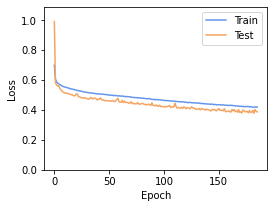

In [19]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(train_loss_list, color='cornflowerblue', label='Train')
ax.plot(test_loss_list, color='sandybrown', label='Test')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_ylim([0, 1.1*np.max(train_loss_list+test_loss_list)])
ax.legend()
plt.show()
fig.savefig(out_dir+"training_plots/AE_"+model_run_date+".png", bbox_inches='tight')

# Load Existing Models

In [47]:
# Check one model exists for this config
model_path = glob.glob(model_dir+"AE_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+str(v2)+"_"+
                model_run_date+"_*.pt")
#
if len(model_path) == 1:
    saved = torch.load(model_path[0])
    print(model_path[0], "loaded.")
else:
    print("Error. More than one model or no model exists.")
    print(model_path)
    print(model_dir+"AE_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+str(v2)+"_"+
                model_run_date+"_*.pt")

/dreambig/qingyi/image_chicago/models/AE_zoom15_8192_1_2209_test_70.pt loaded.


In [48]:
model.load_state_dict(saved['model_state_dict']);
model = model.to(device)
model.eval();

## Reconstruction Results

In [12]:
# Reverse Normalization
# Satellite image
if zoomlevel == 'zoom13':
    mean = [0.3733, 0.3991, 0.3711]
    std = [0.2173, 0.2055, 0.2143]
elif zoomlevel == 'zoom15':
    mean = [0.3816, 0.4169, 0.3868]
    std = [0.1960, 0.1848, 0.2052]

In [21]:
for step, (image_list, data) in enumerate(train_loader):
    data = data.to(device)
    break
recon_imgs = model(data)

In [22]:
import util_image
data = util_image.inverse_transform(data, mean, std)
recon_imgs = util_image.inverse_transform(recon_imgs, mean, std)

[2022/10/04 11:56:05 matplotlib.image WARNING] - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


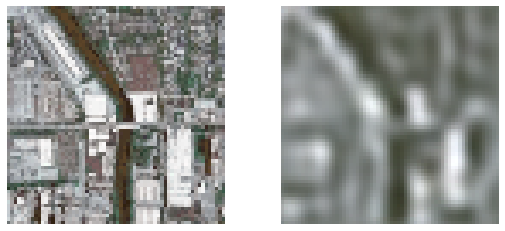

In [23]:
plot_image = 5
fig, ax = plt.subplots(1, 2, figsize=(9,4))
ax[0].imshow(data[plot_image,:,:,:].permute(1,2,0).detach().cpu().numpy())
ax[0].axis('off')
ax[1].imshow(recon_imgs[plot_image,:,:,:].permute(1,2,0).detach().cpu().numpy())
ax[1].axis('off')
plt.show()

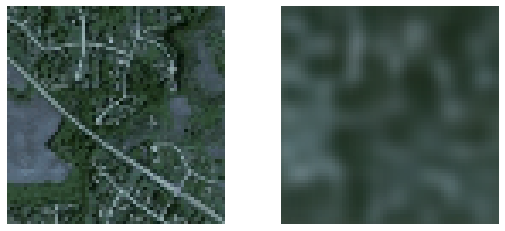

In [24]:
plot_image = 6
fig, ax = plt.subplots(1, 2, figsize=(9,4))
ax[0].imshow(data[plot_image,:,:,:].permute(1,2,0).detach().cpu().numpy())
ax[0].axis('off')
ax[1].imshow(recon_imgs[plot_image,:,:,:].permute(1,2,0).detach().cpu().numpy())
ax[1].axis('off')
plt.show()

In [25]:
from numpy.linalg import svd


In [29]:
u,s,v = svd(data[0,:,:,:].detach().cpu().numpy())

In [30]:
u.shape

(3, 64, 64)

In [31]:
v.shape

(3, 64, 64)

In [33]:
s.shape

(3, 64)

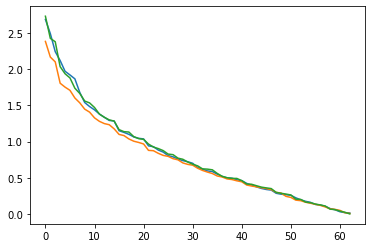

In [37]:
for i in range(len(s)):
    plt.plot(s[i,1:])

In [36]:
s[0,:]

array([2.4229666e+01, 2.6865222e+00, 2.4910827e+00, 2.2418056e+00,
       2.1188781e+00, 1.9710884e+00, 1.9200407e+00, 1.8663369e+00,
       1.6787707e+00, 1.5398824e+00, 1.4839001e+00, 1.4382079e+00,
       1.3803548e+00, 1.3358054e+00, 1.2921437e+00, 1.2845327e+00,
       1.1501528e+00, 1.1270268e+00, 1.1001348e+00, 1.0645791e+00,
       1.0452421e+00, 1.0371490e+00, 9.4112831e-01, 9.2959780e-01,
       8.8270414e-01, 8.5475183e-01, 8.0613852e-01, 7.8979778e-01,
       7.5867778e-01, 7.3741633e-01, 7.2177225e-01, 7.0051301e-01,
       6.4171052e-01, 6.1941808e-01, 5.9512126e-01, 5.8661783e-01,
       5.5045980e-01, 5.2030683e-01, 5.0027573e-01, 4.9529102e-01,
       4.7252151e-01, 4.6134102e-01, 4.2299581e-01, 4.0015543e-01,
       3.7480167e-01, 3.5334113e-01, 3.3902282e-01, 3.3073416e-01,
       2.8668019e-01, 2.7398479e-01, 2.6704580e-01, 2.5866356e-01,
       2.2405832e-01, 1.9642176e-01, 1.7548217e-01, 1.6118406e-01,
       1.3226748e-01, 1.2487987e-01, 1.0644538e-01, 7.5545229e